In [485]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.plotting import register_matplotlib_converters
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.tseries.offsets import MonthEnd

register_matplotlib_converters()
ee.Initialize()

In [486]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied, currently works for 2000 - 2018
3) Scale (optional): Resolution at which to perform analysis (if not specified, calculated automatically in EE)
4) Satellites / datasets: Queried from Earth Engine, defined in data[sat1...] 
'''

##### AREA #####

# CV
cvsa = gp.read_file("../shape/cv.shp")
cv_km3 = round(cvsa.area[0] * 10, 2)* 1000

# HUC 4s draining to the CV 
ssjt = gp.read_file("../shape/cv_hu6.shp")
ssjt2 = ssjt.geometry.simplify(0.1) # This reduces the # of geometries submitted to EE and makes things run mucho faster 
lls = ssjt2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)

# Get the area of the ssjt wshed 
s1 = gp.read_file("../shape/1804_4.shp")
s2 = gp.read_file("../shape/1803_4.shp")
s3 = gp.read_file("../shape/1802_4.shp")
sa_km3 = unary_union([s1.geometry[0], s2.geometry[0], s3.geometry[0]]).area * 10000

# Grace area
ga = gp.read_file("../shape/argus_grace.shp")

##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)

In [487]:
# Read and format data 

In [491]:
df1 = pd.read_csv("../data/RS_DAT_FIN_monthly_2001_2018.csv", parse_dates = True, infer_datetime_format = True)
df2 = pd.read_csv("../data/RS_DAT_FIN_monthly_2001_2018_CVWshed.csv", parse_dates = True, infer_datetime_format = True)

def col_to_dt(df):
    t = df.copy()
    t['dt'] = pd.to_datetime(df[df.columns[0]])
    t = t.set_index(pd.to_datetime(t[t.columns[0]]))
    t.drop([t.columns[0], "dt"],axis = 1, inplace = True)
    
    return t

cv = col_to_dt(df1)
cvw = col_to_dt(df2)

In [496]:
# Apply crop coefficients to Et0 data (CV only)

df3 = pd.read_csv("../data/et_kc.csv")
etdf = col_to_dt(df3)

# Select the first year of scaling factors and apply this to the first 7 years of data
repeat_arr = etdf.et_multiplier[0:12]

# Merge with df
cvet = pd.merge(cv, etdf,how = "outer", left_index = True, right_index = True)
cvet.drop(cvet.tail(12).index,inplace=True)

# Make 7 concats of the yearly dataframe, fill the nans in the cvdf with that
temp = pd.DataFrame(repeat_arr)
temp = pd.concat([temp]*7, ignore_index=True)
cvet.et_multiplier[cvet.et_multiplier.isna()] = temp[temp.columns[0]].values

cv["et_multiplier"] = cvet.et_multiplier

In [497]:
# Scale the PET data by the kc multiplier inplace
for i in [cv.nldas_etr, cv.gldas_etr,cv.modis_pet, cv.tc_pet, cv.gmet_eto]:
    i = i*cv.et_multiplier*0.75
    
# Scale the AET data by the kc multiplier inplace
for i in [cv.fldas_aet, cv.gldas_aet,cv.modis_aet, cv.tc_aet]:
    i = i*cv.et_multiplier*0.75

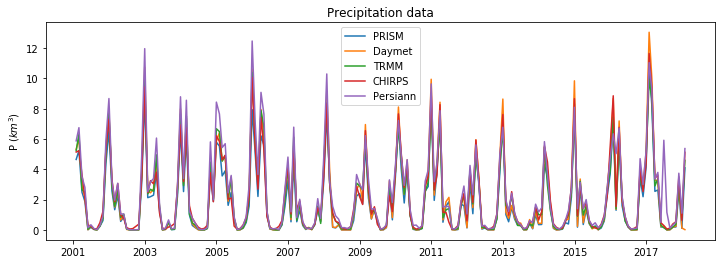

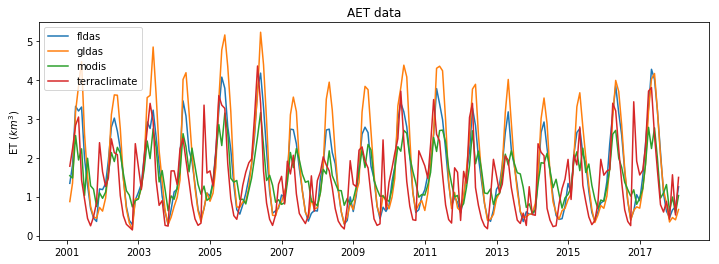

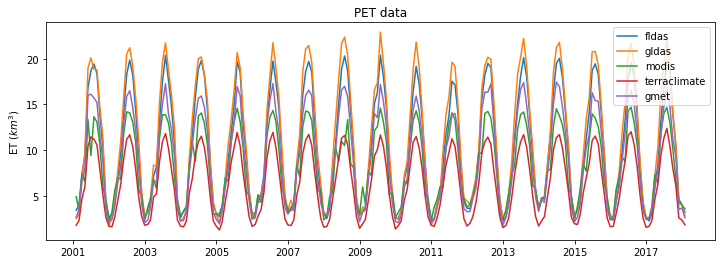

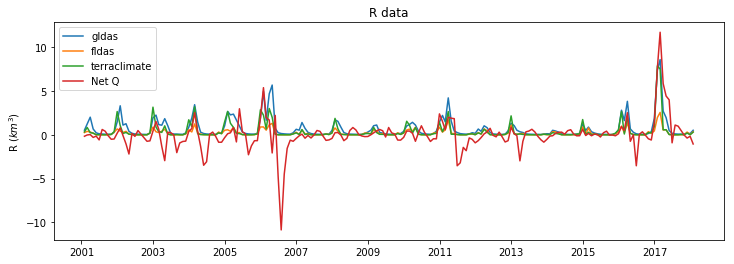

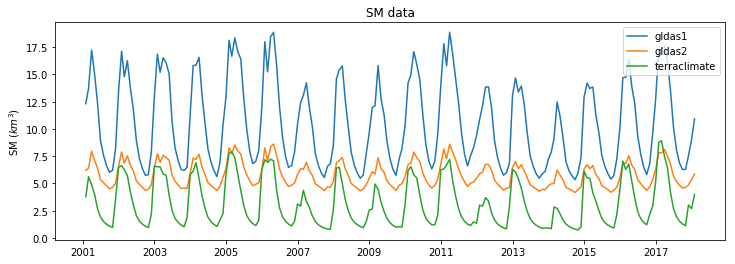

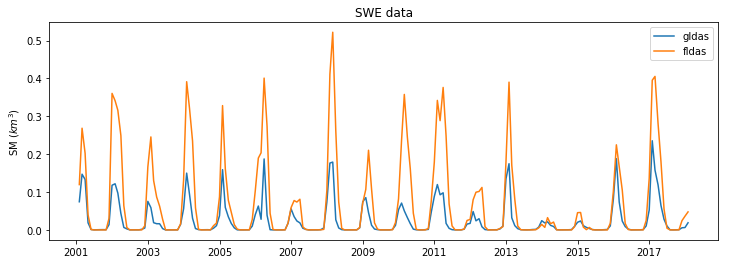

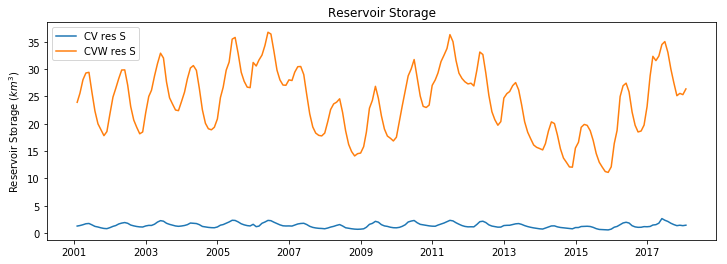

In [525]:
# Plot everything for CV 

plt.figure(figsize = (12,4))
plt.title("Precipitation data")
plt.plot(cv['p_prism'], label = "PRISM")
plt.plot(cv['p_daymet'], label = "Daymet")
plt.plot(cv['p_trmm'], label = "TRMM")
plt.plot(cv['p_chirps'], label = 'CHIRPS')
plt.plot(cv['p_persiann'], label = "Persiann")
plt.ylabel("P ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("AET data")
plt.plot(cv.fldas_aet, label = "fldas")
plt.plot(cv.gldas_aet, label = 'gldas')
plt.plot(cv.modis_aet, label = 'modis')
plt.plot(cv.tc_aet, label = "terraclimate")
plt.ylabel("ET ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("PET data")
plt.plot(cv.nldas_etr, label = "fldas")
plt.plot(cv.gldas_etr, label = 'gldas')
plt.plot(cv.modis_pet, label = 'modis')
plt.plot(cv.tc_pet, label = "terraclimate")
plt.plot(cv.gmet_eto, label = "gmet")
plt.ylabel("ET ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("R data")
plt.plot(cv.gldas, label = "gldas")
plt.plot(cv.fldas_r, label = 'fldas')
plt.plot(cv.tc_r, label = 'terraclimate')
plt.plot(cv.q_in - cv.q_out, label = "Net Q")
plt.ylabel("R ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("SM data")
plt.plot(cv.gldas_sm, label = "gldas1")
plt.plot(cv.gldas_m, label = 'gldas2')
plt.plot(cv.tc_sm, label = "terraclimate")
plt.ylabel("SM ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("SWE data")
plt.plot(cv.gldas_swe, label = "gldas")
plt.plot(cv.fldas_swe, label = 'fldas')
# plt.plot(cv.dmet_swe, label = "terraclimate")
plt.ylabel("SM ($km^3$)")
plt.legend()
plt.show()

plt.figure(figsize = (12,4))
plt.title("Reservoir Storage")
plt.plot(cv.res_s, label = "CV res S")
plt.plot(cvw.res_s, label = "CVW res S")
plt.ylabel("Reservoir Storage ($km^3$)")
plt.legend()
plt.show()


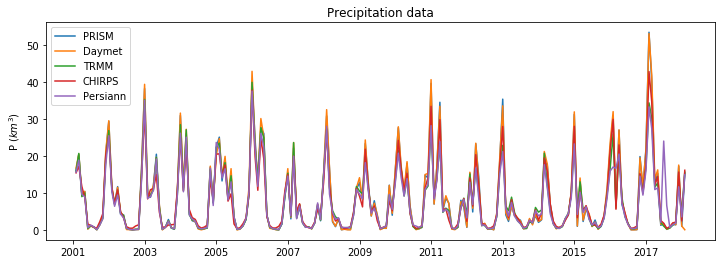

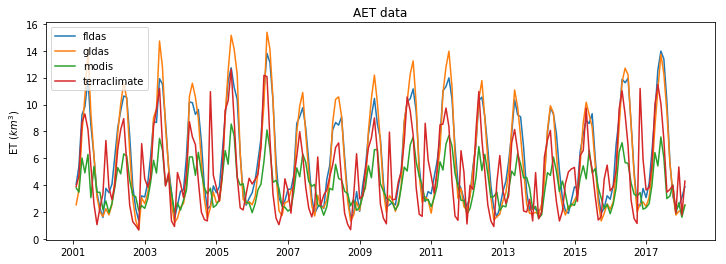

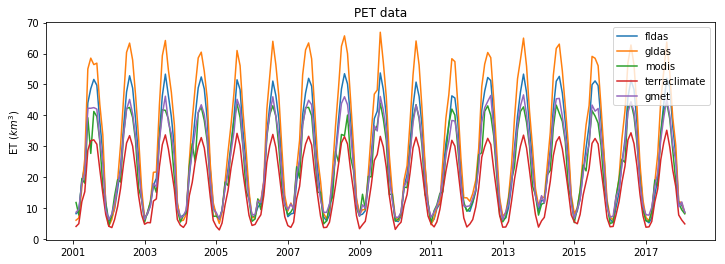

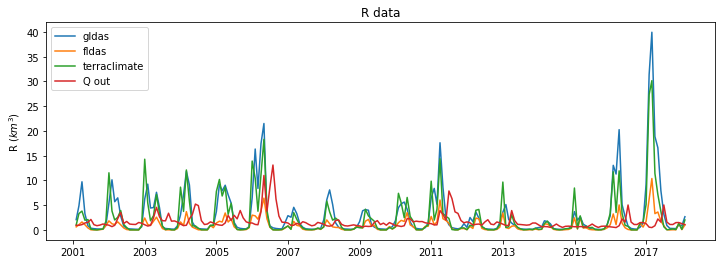

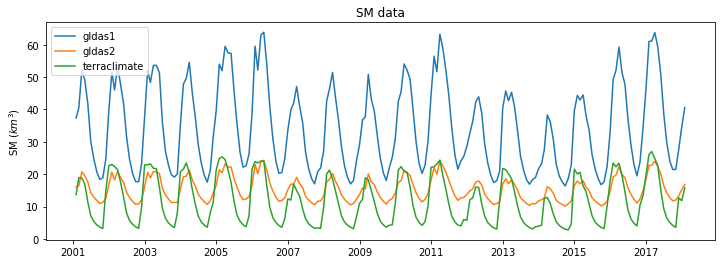

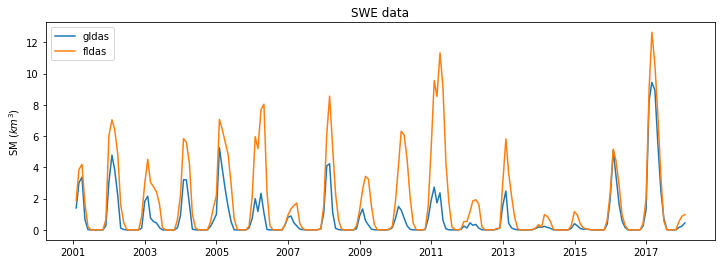

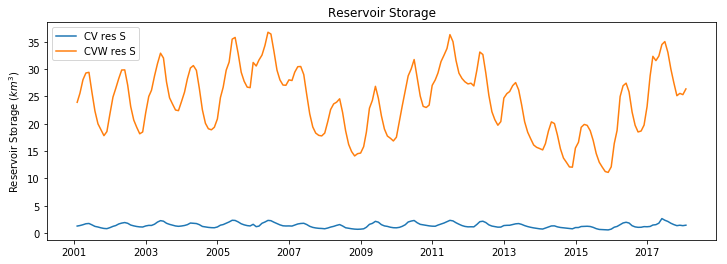

In [539]:
# Plot everything for CV 

plt.figure(figsize = (12,4))
plt.title("Precipitation data")
plt.plot(cvw['p_prism'], label = "PRISM")
plt.plot(cvw['p_daymet'], label = "Daymet")
plt.plot(cvw['p_trmm'], label = "TRMM")
plt.plot(cvw['p_chirps'], label = 'CHIRPS')
plt.plot(cvw['p_persiann'], label = "Persiann")
plt.ylabel("P ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("AET data")
plt.plot(cvw.fldas_aet, label = "fldas")
plt.plot(cvw.gldas_aet, label = 'gldas')
plt.plot(cvw.modis_aet, label = 'modis')
plt.plot(cvw.tc_aet, label = "terraclimate")
plt.ylabel("ET ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("PET data")
plt.plot(cvw.nldas_etr, label = "fldas")
plt.plot(cvw.gldas_etr, label = 'gldas')
plt.plot(cvw.modis_pet, label = 'modis')
plt.plot(cvw.tc_pet, label = "terraclimate")
plt.plot(cvw.gmet_eto, label = "gmet")
plt.ylabel("ET ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("R data")
plt.plot(cvw.gldas, label = "gldas")
plt.plot(cvw.fldas_r, label = 'fldas')
plt.plot(cvw.tc_r, label = 'terraclimate')
plt.plot(cvw.q_out, label = "Q out")
plt.ylabel("R ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("SM data")
plt.plot(cvw.gldas_sm, label = "gldas1")
plt.plot(cvw.gldas_m, label = 'gldas2')
plt.plot(cvw.tc_sm, label = "terraclimate")
plt.ylabel("SM ($km^3$)")
plt.legend()

plt.figure(figsize = (12,4))
plt.title("SWE data")
plt.plot(cvw.gldas_swe, label = "gldas")
plt.plot(cvw.fldas_swe, label = 'fldas')
#plt.plot(cvw.dmet_swet, label = "dmet")
plt.ylabel("SM ($km^3$)")
plt.legend()
plt.show()

plt.figure(figsize = (12,4))
plt.title("Reservoir Storage")
plt.plot(cv.res_s, label = "CV res S")
plt.plot(cvw.res_s, label = "CVW res S")
plt.ylabel("Reservoir Storage ($km^3$)")
plt.legend()
plt.show()


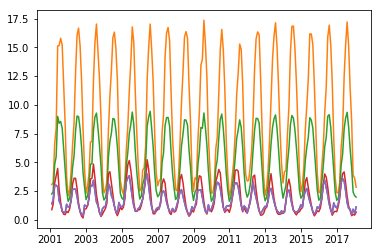

In [557]:
# CV water balance

df = cv.copy()

# Calc means 
df["p_mean"] = np.mean([cv['p_prism'], cv['p_chirps'],cv['p_persiann'],cv['p_trmm'],cv['p_daymet']],axis = 0)
df["aet_mean"] = np.mean([cv['fldas_aet'], cv['gldas_aet'],cv['modis_aet'],cv['tc_aet']],axis = 0)
df["pet_mean"] = np.mean([cv['nldas_etr'], cv['gldas_etr'],cv['modis_pet'],cv['tc_pet'],cv['gmet_eto']],axis = 0)
df['et_mean'] = np.mean([df['pet_mean'], df['aet_mean']],axis = 0)
df['sm_mean'] = np.mean([df['gldas_sm'], df['tc_sm'], df["gldas_m"]],axis = 0)
df['r_mean'] = np.mean([df['gldas'], df['fldas_r'], df["tc_r"], df['q_in']],axis = 0)
df['r_eff'] = np.mean([cvw['gldas'], cvw['fldas_r'], cvw["tc_r"], cvw['q_in']],axis = 0) - np.mean([cv['gldas'], cv['fldas_r'], cv["tc_r"], cv['q_in']],axis = 0)
df['et_eff'] = np.mean([df.pet_mean,df.aet_mean],axis = 0) * 0.75
df['swe_mean'] =  np.mean([df['fldas_swe'],df['gldas_swe']], axis = 0)

plt.plot(df["aet_mean"])
plt.plot(df["pet_mean"])
plt.plot(df["et_mean"])
plt.plot(df['gldas_aet'])
plt.plot(df['aet_mean'])

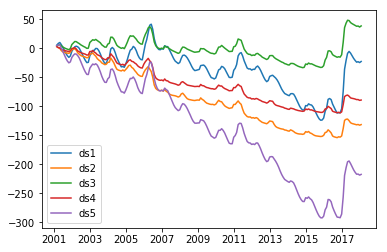

In [818]:

# Do the balances
df["ds1"] = df.p_mean - df.pet_mean*(0.4) - df.q_out + df.q_in +df.r_eff - df.sm_mean.diff() - df.res_s.diff() - df.gldas_swe.diff()
# df["ds1"] = df.p_mean - df.et_mean - df.q_out + df.r_mean + df.q_in - df.tc_sm.diff() - df.res_s.diff() 
df["ds2"] = df.p_mean - df.gldas_aet - df.q_out + df.r_mean - df.sm_mean.diff() - df.res_s.diff() 
df["ds3"] = df.p_mean - df.aet_mean - df.q_out + df.r_eff - df.sm_mean.diff() - df.res_s.diff()
df["ds4"] = df.p_mean - df.aet_mean - df.q_out + df.r_mean - df.sm_mean.diff() - df.res_s.diff() 

df["ds5"] = df.p_mean - df.et_eff - df.q_out + df.r_eff + df.q_in - df.sm_mean.diff() - df.res_s.diff() 

# Plot
plt.plot(np.cumsum(df.ds1))
plt.plot(np.cumsum(df.ds2))
plt.plot(np.cumsum(df.ds3))
plt.plot(np.cumsum(df.ds4))
plt.plot(np.cumsum(df.ds5))
plt.legend()
plt.show()

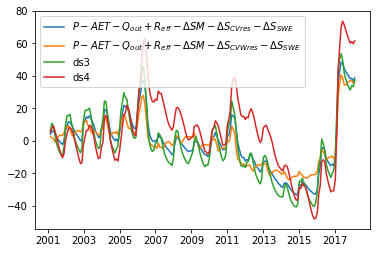

In [788]:
# CV water balance

df = cv.copy()

df["p_mean"] = np.mean([cv['p_prism'], cv['p_chirps'],cv['p_persiann'],cv['p_trmm'],cv['p_daymet']],axis = 0)
df["aet_mean"] = np.mean([cv['fldas_aet'], cv['gldas_aet'],cv['modis_aet'],cv['tc_aet']],axis = 0)
df["pet_mean"] = np.mean([cv['nldas_etr'], cv['gldas_etr'],cv['modis_pet'],cv['tc_pet']],axis = 0)
df['et_mean'] = np.mean([df['pet_mean'], df['aet_mean']],axis = 0)
df['sm_mean'] = np.mean([df['gldas_sm'], df['tc_sm'], df["gldas_m"]],axis = 0)
df['r_mean'] = np.mean([df['gldas'], df['fldas_r'], df["tc_r"], df['q_in']],axis = 0)
df['r_eff'] = np.mean([cvw['gldas'], cvw['fldas_r'], cvw["tc_r"]],axis = 0) - np.mean([cv['gldas'], cv['fldas_r'], cv["tc_r"], cv['q_in']],axis = 0)
df['et_eff'] = np.mean([df.pet_mean/1.2,df.aet_mean],axis = 0)

# Instead of doing Q_in, do effective Runoff (which should capture Q) as R_CVW - R_CV 
df["ds1"] = df.p_mean - df.aet_mean + df.r_eff - df.q_out - df.sm_mean.diff() - df.gldas_swe.diff() - df.res_s.diff()

# Add in the drawdown from all CV reservoirs, which is from inflows but also from releases downstream
df["ds2"] = df.p_mean - df.aet_mean + df.r_eff - df.q_out - df.sm_mean.diff() - df.gldas_swe.diff() - df2.res_s.diff()

# Can essentially perterb the results by changing the sign of the diff in SM, SWE, storage
df["ds3"] = df.p_mean - df.aet_mean - df.q_out + df.r_eff + df.sm_mean.diff() - df.gldas_swe.diff() - df.res_s.diff()

# Use the GLDAS AET, and effective runoff instead of Q_in
df["ds4"] = df.p_mean - df.gldas_aet - df.q_out + df.r_eff - df.sm_mean.diff() - df.res_s.diff() 

# Scale the effective ET by 0.7 - irrigated land / non cropland correction? 
df["ds4"] = df.p_mean - df.et_eff*0.7 + df.r_eff - df.q_out + df.q_in - df.sm_mean.diff() - df.res_s.diff() 


# df["ds1"] = df.p_mean - df.et_mean - df.q_out + df.r_mean + df.q_in - df.sm_mean.diff() - df.res_s.diff() 
# df["ds2"] = df.p_mean - df.aet_mean - df.q_out + df.r_mean - df.sm_mean.diff() - df.res_s.diff() 
df["finalmodel"] = df.p_mean - df.aet_mean - df.q_out + df.r_eff - df.sm_mean.diff() - df.gldas_swe.diff() - df.res_s.diff()
# df["ds4"] = df.p_mean - df.aet_mean - df.q_out + df.r_mean - df.sm_mean.diff() - df.res_s.diff() 

plt.plot(np.cumsum(df.ds1), label = '$P - AET - Q_{out} + R_{eff} - \Delta SM - \Delta S_{CVres} - \Delta S_{SWE}$')
plt.plot(np.cumsum(df.ds2), label = "$P - AET - Q_{out} + R_{eff} - \Delta SM - \Delta S_{CVWres} - \Delta S_{SWE}$")
plt.plot(np.cumsum(df.ds3))
plt.plot(np.cumsum(df.ds4))
plt.legend()
plt.show()

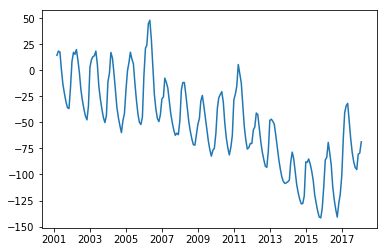

In [794]:
# CVWshed Water balances

df2 = cvw.copy()

df2["p_mean"] = np.mean([cvw['p_prism'], cvw['p_chirps'],cvw['p_persiann'],cvw['p_trmm'],cvw['p_daymet']],axis = 0)
df2["aet_mean"] = np.mean([cvw['fldas_aet'], cvw['gldas_aet'],cvw['modis_aet'],cvw['tc_aet']],axis = 0)
df2["pet_mean"] = np.mean([cvw['nldas_etr'], cvw['gldas_etr'],cvw['modis_pet'],cvw['tc_pet'], cvw['gmet_eto']],axis = 0)
df2['et_mean'] = np.mean([df2['pet_mean'], df2['aet_mean']],axis = 0)
df2['et_eff'] = df2['aet_mean'] - df['aet_mean'] +  df['pet_mean'] * 0.35
df2['sm_mean'] = np.mean([cvw['gldas_sm'], cvw['tc_sm'], cvw["gldas_m"]],axis = 0)
df2['swe_mean'] =  np.mean([cvw['fldas_swe'],cvw['gldas_swe']], axis = 0)
df2['r_mean'] = np.mean([cvw['gldas'], cvw['fldas_r'], cvw["tc_r"], cvw['q_in']],axis = 0)

# ET eff  
df2["ds"] = df2.p_mean - df2.et_eff - df2.q_out + df2.sm_mean.diff() - df2.res_s.diff() - df2.swe_mean.diff()

plt.plot(np.cumsum(df2.ds))

In [797]:
# Grace data

grace = pd.read_csv("../data/grace_argus.csv")

# Initialize the datetime columns
grace['dt'] = pd.to_datetime(grace[grace.columns[0]])
grace = grace.set_index(pd.to_datetime(grace[grace.columns[0]]))
grace.drop(["dt"],axis = 1, inplace = True)

# Subtract reservoir storage, soil moisture, SWE from grace 
grace['adj'] = grace.grace_mean[1:] - df2.sm_mean.diff()[1:] - df2.res_s.diff()[1:] - df2.swe_mean.diff()[1:]

In [798]:
# Wells data (processed by zihan using Faunt 2009 SY values )

wells = pd.read_csv("../data/wells_ds_faunt_sy.csv")
wells.month = wells.month.astype(str)
wells.year = wells.year.astype(str)
wells.month = wells.month.str.zfill(2)

wells['Date'] = pd.to_datetime(wells.year + wells.month , format="%Y%m") + MonthEnd(1)
wells.index = wells.Date
wells.drop(['Date'], axis =1, inplace = True)

wells['ds_km3'] = wells[wells.columns[-1]] * 50000 * 1e-5

In [799]:
# Wells data (processed by zihan using Faunt 2009 SY values )

wells2 = pd.read_csv("../data/dS_well.txt", header = None)
w = wells2[0].str.replace("\t",",")
x = [float(i) for i in w[0].split(',')]
wells['ds_km3_2'] = x

In [800]:
# c2vsim storage data 

c2vs = pd.read_csv("../data/all_data_cv.csv")
c2vs.ds = c2vs.s.diff()[-len(df1):]
df['c2vsim'] = c2vs.s.diff().values[-len(df1):]

In [801]:
# Plot 

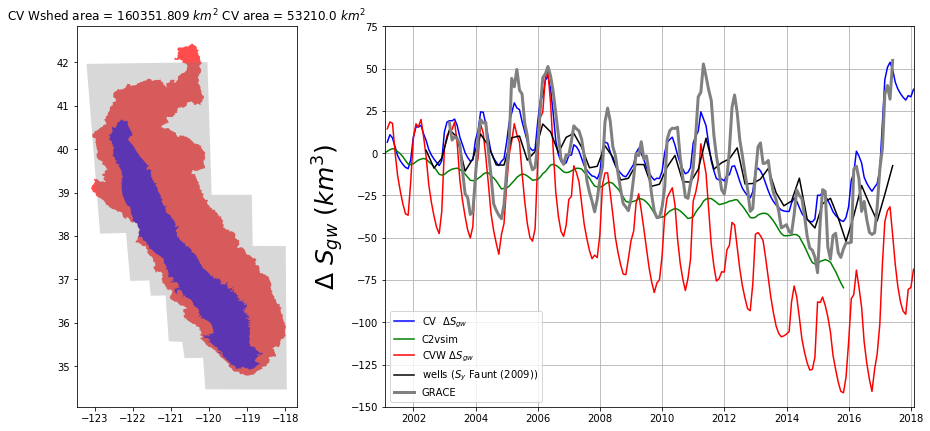

In [807]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
axes_1.set_title("CV Wshed area = {} $km^2$ CV area = {} $km^2$".format(round(sa_km3, 3), round(cv_km3, 1))) 

ssjt.plot(ax=axes_1, color = "red", alpha = 0.7)
cvsa.plot(ax=axes_1, color = "blue", alpha = 0.7)
ga.plot(label = "grace footprint", ax=axes_1, color = "gray", alpha = 0.3, legend = True)

# Plot the timeseries
axes_4 = plt.subplot(G[0:2, 1:])
axes_4.plot(df.index, np.cumsum(df.ds3), color="blue", label = "CV  $\Delta S_{gw}$")
axes_4.plot(df.index, np.cumsum(df.c2vsim), color="green", label = "C2vsim")
axes_4.plot(df2.index, np.cumsum(df2.ds), color="red", label = "CVW $\Delta S_{gw}$ ")
axes_4.plot(wells.index, wells.ds_km3_2, color="black", label = "wells ($S_y$ Faunt (2009))")
axes_4.plot(grace.index, grace.adj, color="gray", linewidth = 3, label = "GRACE")

axes_4.set_ylim(-150,75)
axes_4.set_xlim(df.index[0],df.index[-1])

axes_4.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 25) 
axes_4.legend(loc = "lower left")

plt.grid(True)
G.update(wspace=0.4, hspace=0.3) # set the spacing between axes. 

# plt.tight_layout()
plt.show()

In [450]:
# Read xiao hydrology model

x = pd.read_csv("../data/xiao_ds.txt", header = None, sep = " ")
x['dt'] = pd.to_datetime(x[x.columns[0]])
x = x.set_index(pd.to_datetime(x[x.columns[0]]))
x.drop([x.columns[0],x.columns[1], 'dt'],axis = 1, inplace = True)

In [451]:
# read xiao grace data 

gr = pd.read_csv("../data/grace_xiao.csv", header = None, sep = ",")
gr['dt'] = pd.to_datetime(gr[gr.columns[0]])
gr = gr.set_index(pd.to_datetime(gr[gr.columns[0]]))
gr.drop([gr.columns[0], 'dt'],axis = 1, inplace = True)

AttributeError: 'DataFrame' object has no attribute 'ds1'

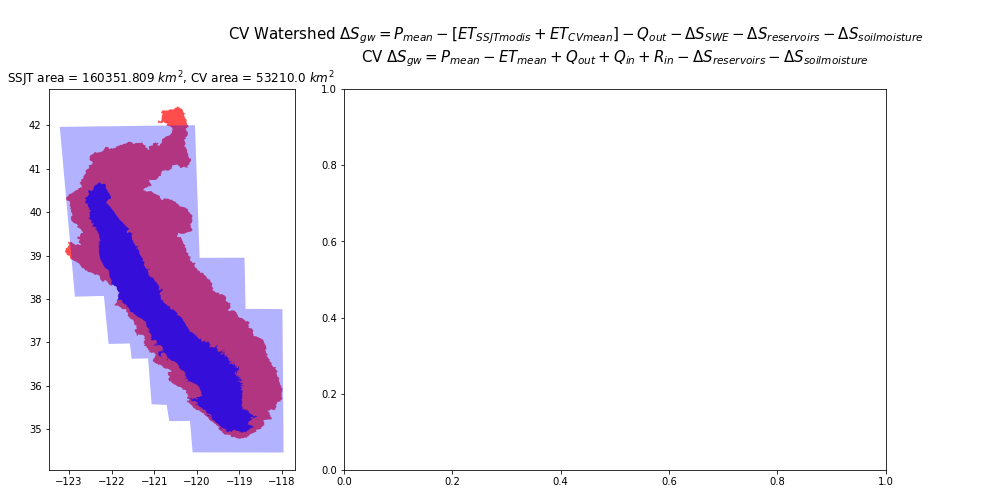

In [455]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "red", alpha = 0.7)
cvsa.plot(ax=axes_1, color = "blue", alpha = 0.7)
ga.plot(label = "grace footprint", ax=axes_1, color = "blue", alpha = 0.3, legend = True)
axes_1.set_title("SSJT area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 3), round(cv_km3, 3)))

axes_4 = plt.subplot(G[0:2, 1:])
axes_4.set_title("""
CV Watershed $\Delta S_{gw} = P_{mean} - [ET_{SSJT modis} + ET_{CV mean}] - Q_{out} - \Delta S_{SWE} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$                 
CV $\Delta S_{gw} = P_{mean} - ET_{mean} + Q_{out} + Q_{in} + R_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture} $
""", size = 15)

axes_4.plot(df.index, np.cumsum(df.s), color="red", label = "RS - CV Watershed")
axes_4.plot(cvdf.index, np.cumsum(cvdf.ds), color="purple", label = "RS - CV ")
axes_4.plot(cvdf.index[1:], np.cumsum(cvdf.s.diff()[1:]), color="blue", label = "C2VSIM")
# axes_4.plot(wells.index, wells.ds_km3, color="black", label = "wells1")
axes_4.plot(wells.index, wells.ds_km3_2, color="black", label = "wells")
axes_4.plot(grace.index, grace.adj, color="green", label = "grace")
# axes_4.plot(grace.index, grace.adj, color="green", label = "grace")
axes_4.plot(gr.index, gr[gr.columns[0]], color="orange", label = "grace (Xiao et al., 2017)")
axes_4.plot(x.index, x[x.columns[0]], color="gray", label = "Xiao et al., 2017")


axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15) 
axes_4.legend()

plt.grid(True)
G.update(wspace=0.3, hspace=0.1) # set the spacing between axes. 
# plt.tight_layout()
plt.show()

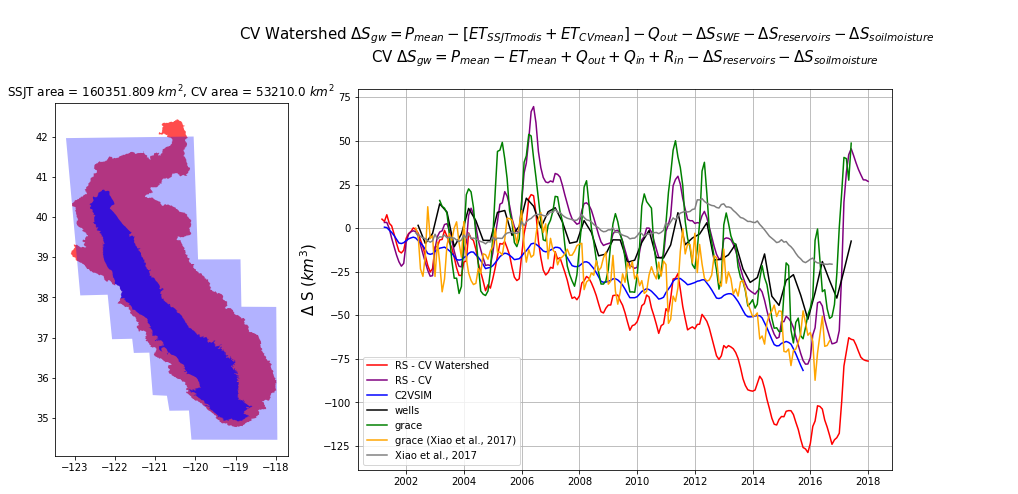

In [13]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "red", alpha = 0.7)
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
ga.plot(label = "grace footprint", ax=axes_1, color = "blue", alpha = 0.3, legend = True)
axes_1.set_title("SSJT area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 3), round(cv_km3, 3)))

axes_4 = plt.subplot(G[0:2, 1:])
axes_4.set_title("""
CV Watershed $\Delta S_{gw} = P_{mean} - [ET_{SSJT modis} + ET_{CV mean}] - Q_{out} - \Delta S_{SWE} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$                 
CV $\Delta S_{gw} = P_{mean} - ET_{mean} + Q_{out} + Q_{in} + R_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture} $
""", size = 15)

axes_4.plot(df.index, np.cumsum(df.ds), color="red", label = "RS - CV Watershed")
axes_4.plot(cvdf.index, np.cumsum(cvdf.ds), color="purple", label = "RS - CV ")
axes_4.plot(cvdf.index[1:], np.cumsum(cvdf.s.diff()[1:]), color="blue", label = "C2VSIM")
# axes_4.plot(wells.index, wells.ds_km3, color="black", label = "wells1")
axes_4.plot(wells.index, wells.ds_km3_2, color="black", label = "wells")
axes_4.plot(grace.index, grace.adj, color="green", label = "grace")
# axes_4.plot(grace.index, grace.adj, color="green", label = "grace")
axes_4.plot(gr.index, gr[gr.columns[0]], color="orange", label = "grace (Xiao et al., 2017)")
axes_4.plot(x.index, x[x.columns[0]], color="gray", label = "Xiao et al., 2017")


axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15) 
axes_4.legend()

plt.grid(True)
G.update(wspace=0.3, hspace=0.1) # set the spacing between axes. 
# plt.tight_layout()
plt.show()

In [104]:
# Do triple collocation on grace, wells, rs model

def calc_tc_error(x,y,z):
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    return ((src - np.mean(src)) /
            np.std(src)) * np.std(ref) + np.mean(ref)

In [176]:
x = np.cumsum(cvdf.ds)
y = wells.ds_km3_2
z = grace.adj


In [177]:
y_scaled = scale_to_ref(y, x)
z_scaled = scale_to_ref(z, x)

In [178]:
e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)
print (e_x,e_y,e_z)

8.42149614962854 14.308557935103192 16.511434844096385


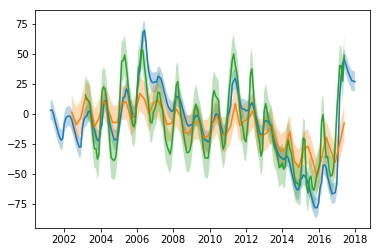

In [179]:
plt.plot(cvdf.index, x)
plt.fill_between(cvdf.index, x+e_x, x-e_x, alpha = 0.3)
plt.plot(wells.index, y)
plt.fill_between(wells.index, y+e_y, y-e_y, alpha = 0.3)
plt.plot(grace.index, z)
plt.fill_between(grace.index, z+e_z, z-e_z, alpha = 0.3)

In [127]:
t1 = pd.merge(cvdf, wells, left_index=True, right_index=True, how = "outer")
t2 = pd.merge(t1, grace, left_index=True, right_index=True, how = "outer")

In [161]:
t2['cs'] = np.cumsum(t2.ds)
t2['ds_mean'] = np.nanmean(t2[['adj', 'ds_km3', "cs"]], axis = 1)

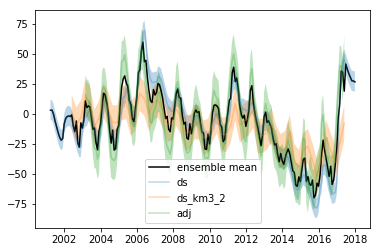

In [171]:
plt.plot(t2.ds_mean, color = "black", label = 'ensemble mean')
plt.plot(cvdf.index, x, alpha = 0.3)
plt.fill_between(cvdf.index, x+e_x, x-e_x, alpha = 0.3)
plt.plot(wells.index, y, alpha = 0.3)
plt.fill_between(wells.index, y+e_y, y-e_y, alpha = 0.3)
plt.plot(grace.index, z, alpha = 0.3)
plt.fill_between(grace.index, z+e_z, z-e_z, alpha = 0.3)
plt.legend()